### Pretrained Resnet using custom soccer dataset ###
1.Iswariya Manivannan<br>
2.Sathiya Ramesh

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torchvision.models as models
from torch.autograd import Variable
import torch.utils.data as utils_data
from torch.utils.data.sampler import SubsetRandomSampler
%matplotlib inline
import matplotlib.pyplot as plt 
import numpy as np
import copy

torch.manual_seed(40)
torch.cuda.manual_seed(40)
np.random.seed(2)

In [2]:
cuda0 = torch.device('cuda:0')
print(cuda0)
print(torch.cuda.is_available())

cuda:0
True


In [42]:
transform = transforms.Compose([transforms.Resize((224,224)), transforms.RandomHorizontalFlip(),
                               transforms.ToTensor(),
                               transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

trainset = dsets.ImageFolder('/opt/datasets/Robocup_soccer/train', transform)
valset = dsets.ImageFolder('/opt/datasets/Robocup_soccer/valid', transform)
testset = dsets.ImageFolder('/opt/datasets/Robocup_soccer/test', transform)
print(trainset.class_to_idx)
print(valset.class_to_idx)
print(testset.class_to_idx)

{'with_ball': 0, 'without_ball': 1}
{'with_ball': 0, 'without_ball': 1}
{'with_ball': 0, 'without_ball': 1}


In [43]:
print(len(trainset))
batch_size = 16
trainloader = utils_data.DataLoader(trainset, batch_size = batch_size, shuffle = True, num_workers=2)
valloader = utils_data.DataLoader(valset, batch_size = batch_size, shuffle = True, num_workers=2)
testloader = utils_data.DataLoader(testset, batch_size = batch_size, shuffle = True, num_workers=2)

1011


In [44]:
len(valloader.sampler)

100

In [45]:
# Function to train the model
def fit(dataloader, model, phase = 'Training'):
    
    if phase == 'Training':
        model.train()
    if phase == 'Validation':
        model.eval()
     
    running_loss = 0
    running_pred = 0

    for i, (images, labels) in enumerate(dataloader):


        # Feeding data to GPU 

        if torch.cuda.is_available():
            Images = Variable(images.to(device = cuda0))
            Labels = Variable(labels.to(device = cuda0))
            ones = torch.ones(Labels.size(), dtype = torch.long, device= cuda0)
            zeros = torch.zeros(Labels.size(), dtype = torch.long, device= cuda0)
        else:
            Images = Variable(images)
            Labels = Variable(labels)
            ones = torch.ones(Labels.size(), dtype = torch.long)
            zeros = torch.zeros(Labels.size(), dtype = torch.long)
            
            
        #Forward
        y_pred = model(Images)
        y_pred_prob = torch.sigmoid(y_pred)

        
        #Loss Function
        loss = criterion(y_pred, Labels.view(-1,1).float())
        
        running_loss += loss.data[0]
        
        if phase == 'Training':
            #Backward
            optimizer.zero_grad()
            loss.backward()

            #Update weights
            optimizer.step()
            
        # Finding the number of correct predictions in the training set
        
        pred_labels = torch.where(y_pred_prob>=0.5, ones, zeros)

        running_pred += (pred_labels[:,1].cpu() == Labels.data.cpu()).sum()



    
    acc = 100. * (running_pred.numpy()/len(dataloader.sampler))
        
    return running_loss/len(dataloader), acc

In [46]:
input_dim = 3*32*32
output_dim = 1
learning_rate = 0.01 
num_epochs = 20
resnet = models.resnet101(pretrained = True)

In [47]:
for param in resnet.parameters():
    param.requires_grad = False

In [48]:
# Changing the output dim of last layer of network
num_features = resnet.fc.in_features
resnet.fc = nn.Linear(num_features, output_dim)

if torch.cuda.is_available():
    resnet.to(device = cuda0)

criterion = nn.BCEWithLogitsLoss()

if torch.cuda.is_available():
    criterion = criterion.to(device = cuda0)
    
optimizer = optim.Adam(resnet.fc.parameters(), lr = learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience =2)

best_acc = 0
best_model_params = resnet.state_dict()
train_loss_values =[]
train_acc_values =[]

val_loss_values =[]
val_acc_values =[]

for epoch in range(num_epochs):   
    
    train_loss, train_acc = fit(trainloader, resnet, phase = 'Training')  # Training set accuracy
    train_loss_values.append(train_loss)
    train_acc_values.append(train_acc)

    val_loss, val_acc = fit(valloader, resnet, phase = 'Validation')  # Validation set loss & accuracy
    val_loss_values.append(val_loss)
    val_acc_values.append(val_acc)
    
    if val_acc > best_acc:
        best_acc = val_acc
        best_model_params = copy.deepcopy(resnet.state_dict())
    
    scheduler.step(val_loss)
    
    
    print(f'Epoch: {epoch}   Train Loss: {train_loss.cpu().numpy():.5f}   Train Acc:{train_acc:.5f}% \
    Val Loss: {val_loss.cpu().numpy():.5f}  Val Acc:{val_acc:.5f}% ')

/home/imaniv2s/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:37: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: 0   Train Loss: 0.81244   Train Acc:65.28190%     Val Loss: 0.68791  Val Acc:66.00000% 
Epoch: 1   Train Loss: 0.63933   Train Acc:72.10682%     Val Loss: 0.81405  Val Acc:67.00000% 
Epoch: 2   Train Loss: 0.56859   Train Acc:74.48071%     Val Loss: 0.53538  Val Acc:72.00000% 
Epoch: 3   Train Loss: 0.60753   Train Acc:74.18398%     Val Loss: 1.07045  Val Acc:64.00000% 
Epoch: 4   Train Loss: 0.74650   Train Acc:70.32641%     Val Loss: 0.50038  Val Acc:80.00000% 
Epoch: 5   Train Loss: 0.55378   Train Acc:77.44807%     Val Loss: 0.49416  Val Acc:79.00000% 
Epoch: 6   Train Loss: 0.49941   Train Acc:78.43719%     Val Loss: 0.54993  Val Acc:79.00000% 
Epoch: 7   Train Loss: 0.51881   Train Acc:76.16222%     Val Loss: 0.62071  Val Acc:73.00000% 
Epoch: 8   Train Loss: 0.49879   Train Acc:78.53610%     Val Loss: 0.50974  Val Acc:76.00000% 
Epoch: 9   Train Loss: 0.39625   Train Acc:82.49258%     Val Loss: 0.58297  Val Acc:69.00000% 
Epoch: 10   Train Loss: 0.38197   Train Acc:81.701

In [49]:
resnet.load_state_dict(best_model_params)
torch.save(resnet.state_dict(), "Resnet_for_soccer_ball.th")

Text(0,0.5,'Percentage Accuracy')

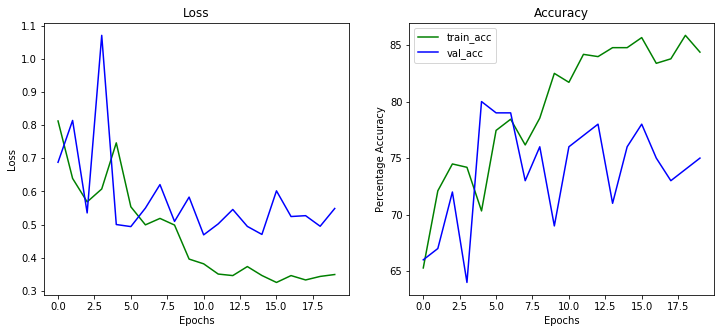

In [50]:
#Plotting the cost function
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(1,2,1)
ax.set_title("Loss")
ax.plot(train_loss_values, '-', color='green')
ax.plot(val_loss_values, '-', color='blue')
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
#ax.set_yscale('log')

ax1 = fig.add_subplot(1,2,2)
ax1.set_title("Accuracy")
ax1.plot(train_acc_values, '-', color='green')
ax1.plot(val_acc_values, '-', color='blue')
ax1.legend(['train_acc', 'val_acc', 'test_acc'],loc='best')
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Percentage Accuracy")

In [51]:
# Function to get predictions for test data and the accuracy on it
def predict(model, testloader):
    
    model.eval()
    pred_val = 0
    prediction_array = np.array([])
    labels_array = np.array([])
    running_pred = 0
    
    for images, labels in testloader:

        # Feeding data to GPU 

        if torch.cuda.is_available():
            Images = Variable(images.cuda())
            Labels = Variable(labels.cuda())
            ones = torch.ones(Labels.size(), dtype = torch.long, device= cuda0)
            zeros = torch.zeros(Labels.size(), dtype = torch.long, device= cuda0)
        else:
            Images = Variable(images)
            Labels = Variable(labels)
            ones = torch.ones(Labels.size(), dtype = torch.long)
            zeros = torch.zeros(Labels.size(), dtype = torch.long)

        #Forward
        y_pred_prob = model(Images)
        
        # Finding the number of correct predictions in the test set
        
        pred_labels = torch.where(y_pred_prob>=0.5, ones, zeros)

        pred_val += (pred_labels[:,1].cpu() == Labels.data.cpu()).sum()
        
        # Storing predictions and true labels in numpy arrays for printing confusion matrix
        prediction_array = np.append(prediction_array, pred_labels[:,1].cpu().numpy(), axis =0)
        labels_array = np.append(labels_array, Labels.data.cpu().numpy(), axis = 0)
        

    Test_acc = 100. * (pred_val.numpy()/len(testloader.sampler))
    return Test_acc, prediction_array, labels_array
   

In [52]:
Test_acc, Predicted_labels, True_labels = predict(resnet,testloader) # Test set accuracy

print(f'Test Accuracy:{Test_acc:.5f}% ')

Test Accuracy:70.58824% 


In [53]:
#Confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(True_labels, Predicted_labels)
print(cm)

[[103   0]
 [ 60  41]]


['with_ball', 'without_ball']


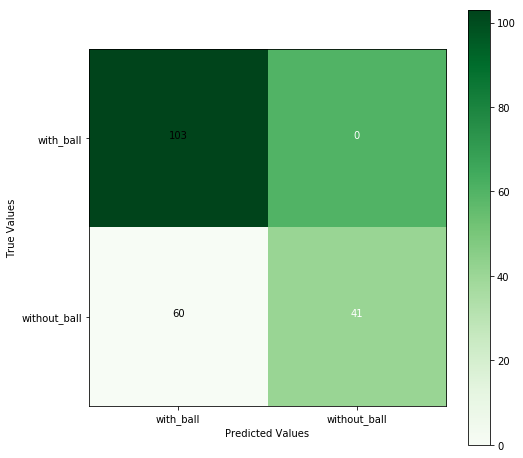

In [56]:
# Plotting confusion matrix
import itertools
def plot_confusion_matrix(cm, classes):
    
    cmap = plt.get_cmap('Greens')
    plt.figure(figsize=(8,8))
    plt.imshow(cm, cmap = cmap, interpolation = 'nearest')
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    print(classes)
    plt.xlabel("Predicted Values")
    plt.ylabel("True Values")
    
    threshold = cm.max()/2
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        
        plt.text(i, j, f'{cm[i, j]}' , horizontalalignment = 'center', 
                 color="white" if cm[i, j] < threshold else "black")

plot_confusion_matrix(cm.T, ['with_ball', 'without_ball'])

In [ ]:
a = torch.tensor([[1,0,1],[1,0,1],[4,3,2]])
b = torch.tensor([[-1,0,1],[1,0,1],[1,2,3]])
